In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1736167152.518344
Mon Jan  6 04:39:12 2025


In [2]:
from pennylane import broadcast
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [3]:
N_train = 1800             # Number of training points
noise_0 = 0.001                            # Initial spread of random weight vector
N_test = 600                               # Number of test points
N_tot = N_train + N_test  

In [4]:
def twospirals(n_points, noise=0.7, turns=1.52, random_state=None):
        """Returns the two spirals dataset."""
       
        if random_state == None:
            rng_sp = np.random
        else:
            rng_sp = np.random.RandomState(random_state) 
        n = np.sqrt(rng_sp.rand(n_points, 1)) * turns * (2 * np.pi)
        d1x = -np.cos(n) * n + rng_sp.rand(n_points, 1) * noise
        d1y = np.sin(n) * n + rng_sp.rand(n_points, 1) * noise
        return (np.vstack((np.hstack((d1x,  d1y)),np.hstack((-d1x, -d1y)))), 
                np.hstack((np.zeros(n_points).astype(int),np.ones(n_points).astype(int))))

datasets = [twospirals(N_tot, random_state=21, turns=1.52),
            twospirals(N_tot, random_state=21, turns=2.0),
           ]

def digits2position(vec_of_digits, n_positions):
        """One-hot encoding of a batch of vectors. """
        return torch.tensor(np.eye(n_positions)[vec_of_digits])

def position2digit(exp_values):
        """Inverse of digits2position()."""
        return np.argmax(exp_values)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cm = plt.cm.RdBu                           # Test point colors
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Train point colors

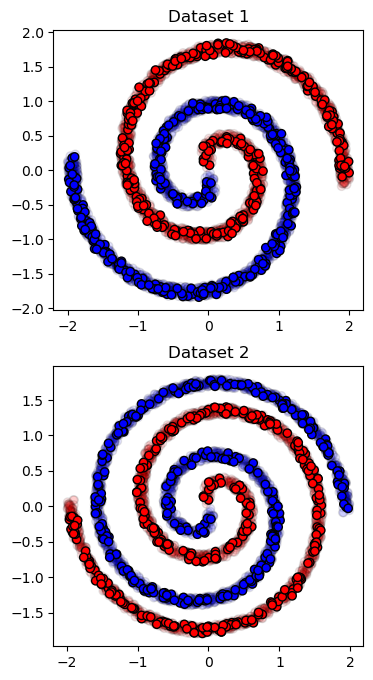

In [7]:
figure_dataset = plt.figure("dataset",figsize=(4, 4 * len(datasets)))
for ds_cnt, ds in enumerate(datasets):
        
        # Normalize dataset and split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, random_state=42)
        
        # Plot the dataset
        ax = plt.subplot(len(datasets), 1, ds_cnt +1)
        ax.set_title("Dataset %d" % (ds_cnt+1))
        
        # Plot training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                edgecolors='k',alpha=0.1)
        
        # Plot test points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                edgecolors='k')

In [8]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

In [9]:
import pennylane as qml

n_qubits = 10
dev = qml.device("default.qubit", wires=n_qubits)

def H_layer(n_qubits):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

def custom_rot_layer(weights, wires):
    for i, wire in enumerate(wires):
        phi, theta, omega = weights[i]
        qml.Rot(phi, theta, omega, wires=wire)

def entangling_layer(wires, measured_1, measured_2):
    for j in range(len(wires) - 1):
        qml.CNOT(wires=[wires[j], wires[j + 1]])
        qml.cond(measured_1, qml.CRZ)(np.pi / 2, wires=[wires[j], wires[j + 1]])
        qml.cond(measured_2, qml.CRY)(np.pi / 4, wires=[wires[j], wires[j + 1]])

@qml.qnode(dev)
def qnode(inputs, weights, x, z):
    H_layer(n_qubits)

    for i in range(n_layers):
        if i % 2 == 0:
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        else:
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Z')
        
        measured_1 = qml.measure(1)
        measured_2 = qml.measure(2)
        entangling_layer(range(n_qubits), measured_1, measured_2)
        custom_rot_layer(weights[i], range(n_qubits))

    custom_rot_layer(weights[-1], range(n_qubits))
    qml.cond(measured_2, qml.CRZ)(z, wires=(3, 0))
    H_layer(n_qubits)

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)], qml.probs(op=measured_2)

In [16]:
n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}
weight_shapes

{'weights': (5, 10)}

In [11]:
w = np.random.random(size=(n_layers, n_qubits))
fig, ax = qml.draw_mpl(qnode, show_all_wires=True, decimals=2, expansion_strategy="device")(w,w)
fig.show()

/global/homes/g/gzquse/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/pennylane/drawer/draw.py:37: PennyLaneDeprecationWarning: The 'expansion_strategy' argument is deprecated and will be removed in version 0.39. Instead, use the 'level' argument which offers more flexibility and options.
  warnings.warn(


TypeError: qnode() missing 2 required positional arguments: 'x' and 'z'

In [ ]:
print(qml.draw(qnode, expansion_strategy="device")(w,w))

In [54]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [25]:
loss_func = torch.nn.L1Loss()

In [55]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 7)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_3 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_4 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_5 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_6 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_7 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(70, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2, x_3, x_4, x_5, x_6, x_7 = torch.split(x, 1, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x_3 = self.qlayer_3(x_3)
        x_4 = self.qlayer_4(x_4)
        x_5 = self.qlayer_5(x_5)
        x_6 = self.qlayer_6(x_6)
        x_7 = self.qlayer_7(x_7)
        x = torch.cat([x_1, x_2, x_3, x_4, x_5, x_6, x_7], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
from matplotlib.colors import ListedColormap
h=0.2
cm = plt.cm.RdBu                           # Test point colors
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Train point colors

In [ ]:
figure_main = plt.figure("main",figsize=(4 * (2 + 1), 4 * 2))
X = torch.tensor(X, requires_grad=True).float()
X = X.detach().numpy()

#y_hot = y_hot.float()

batch_size = 5
batches = len(X) // batch_size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=149)
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, requires_grad=True).float()
y_train_hot = digits2position(y_train, 2)

X_test = torch.tensor(X_test, requires_grad=True).float()
y_test_hot = digits2position(y_test, 2)

# plot settings
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

train_dataset = TensorDataset(X_train, y_train_hot)
test_dataset = TensorDataset(X_test, y_test_hot)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, drop_last=True)

X_train = X_train.detach().numpy()
X_test = X_test.detach().numpy()

# plot the training dataset
ax = plt.subplot(2, 2 + 1, 1)
# plot training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        edgecolors='k', alpha=0.1)

# Plot test points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
        edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

opt = torch.optim.Adam(model.parameters(), lr=0.0004)

train_acc_history = []
test_acc_history = []

# iterate
grid_points = np.c_[xx.ravel(), yy.ravel()]

epochs = 100

for epoch in range(epochs):
    train_running_loss = 0
    test_running_loss = 0
    for xs, ys in train_loader:
        opt.zero_grad()

        loss_evaluated = loss_func(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        train_running_loss += loss_evaluated.item()
        
    train_avg_loss = train_running_loss / batches

    print(f"Train - Epoch {epoch + 1}: Loss: {train_avg_loss:.4f}")
    
    X_train = torch.tensor(X_train, requires_grad=True).float()
    # Calculate train accuracy
    y_pred_train = model(X_train)
    predictions_train = torch.argmax(y_pred_train, axis=1).detach().numpy()

    correct_train = [1 if p == p_true else 0 for p, p_true in zip(predictions_train, y_train)]
    train_accuracy = sum(correct_train) / len(correct_train)
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_acc_history.append(train_accuracy)
    
    # Calculate testmodel.eval()
    with torch.no_grad():
        X_test = torch.tensor(X_test, requires_grad=True).float()
        y_pred_test = model(X_test)
        predictions_test = torch.argmax(y_pred_test, axis=1).detach().numpy()
        correct_test = [1 if p == p_true else 0 for p, p_true in zip(predictions_test, y_test)]
        test_accuracy = sum(correct_test) / len(correct_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        test_acc_history.append(test_accuracy)
        
    # In order to draw the decision border we 
    # compute predictions for the whole 2D plane.

    grid_points = torch.tensor(grid_points, requires_grad=True).float()
    grid_results = model(grid_points).detach().numpy()
    Z = np.tanh(grid_results[:, 1] - grid_results[:, 0])
    Z = Z.reshape(xx.shape)

    # Add subplot to the main figure.
    ax = plt.subplot(2, 2 + 1, 2)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    X_train = X_train.detach().numpy()
    X_test = X_test.detach().numpy()
    # Plot training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
            edgecolors='k', alpha=0.1)
    
    # Plot test points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
            edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

Train - Epoch 1: Loss: 0.3483
Train Accuracy: 56.43%
Test Accuracy: 57.92%
Train - Epoch 2: Loss: 0.3351
Train Accuracy: 63.07%
Test Accuracy: 63.33%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 3: Loss: 0.3094
Train Accuracy: 65.36%
Test Accuracy: 65.42%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 4: Loss: 0.2863
Train Accuracy: 67.59%
Test Accuracy: 67.92%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 5: Loss: 0.2623
Train Accuracy: 74.20%
Test Accuracy: 74.58%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 6: Loss: 0.2373
Train Accuracy: 75.30%
Test Accuracy: 76.60%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 7: Loss: 0.2209
Train Accuracy: 76.04%
Test Accuracy: 76.67%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 8: Loss: 0.2103
Train Accuracy: 76.46%
Test Accuracy: 77.36%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 9: Loss: 0.2029
Train Accuracy: 76.37%
Test Accuracy: 77.71%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 10: Loss: 0.1972
Train Accuracy: 76.76%
Test Accuracy: 78.26%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 11: Loss: 0.1928
Train Accuracy: 76.73%
Test Accuracy: 77.92%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 12: Loss: 0.1893
Train Accuracy: 77.08%
Test Accuracy: 78.12%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 13: Loss: 0.1864
Train Accuracy: 77.29%
Test Accuracy: 78.19%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 14: Loss: 0.1838
Train Accuracy: 77.56%
Test Accuracy: 78.82%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 15: Loss: 0.1816
Train Accuracy: 77.41%
Test Accuracy: 78.89%


/tmp/ipykernel_1095160/4004326545.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


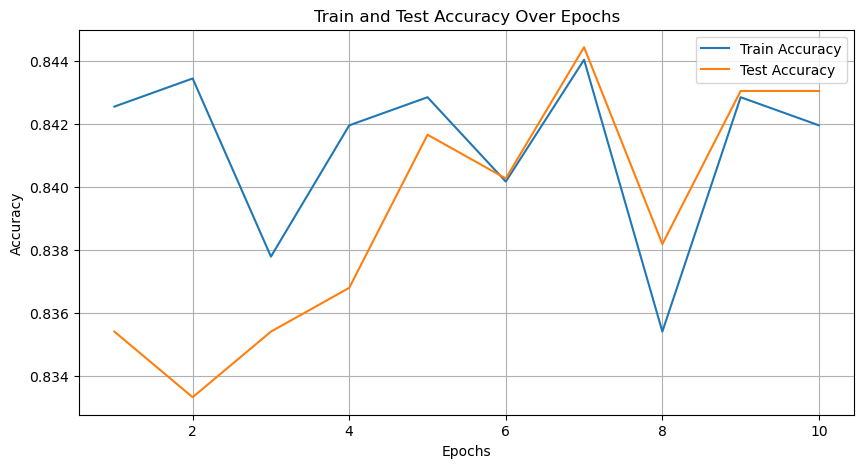

In [53]:
# Plot accuracy history
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc_history, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train and Test Accuracy Over Epochs")
plt.grid(True)
plt.show()

In [ ]:
# Set up the main figure
plt.figure(figsize=(8, 6))
cm = plt.cm.RdBu

# Calculate decision boundary on the grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_tensor = torch.tensor(grid_points, requires_grad=True).float()
grid_results = model(grid_points_tensor).detach().numpy()
Z = np.tanh(grid_results[:, 1] - grid_results[:, 0])  # Assuming binary classification
Z = Z.reshape(xx.shape)

# Plot decision boundary
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1], label="Decision Boundary")

# Plot training data
for label, color, marker in zip([0, 1], ["blue", "red"], ["o", "^"]):
    plt.scatter(
        X_train[y_train == label, 0],
        X_train[y_train == label, 1],
        c=color,
        marker=marker,
        edgecolors="k",
        label=f"Class {label} (Train)",
        alpha=0.7,
    )

# Plot test data
for label, color, marker in zip([0, 1], ["blue", "red"], ["x", "s"]):
    plt.scatter(
        X_test[y_test == label, 0],
        X_test[y_test == label, 1],
        c=color,
        marker=marker,
        edgecolors="k",
        label=f"Class {label} (Test)",
        alpha=0.9,
    )

# Add plot settings
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.legend(loc="upper left")
plt.title("Decision Boundary and Dataset Visualization")
plt.show()


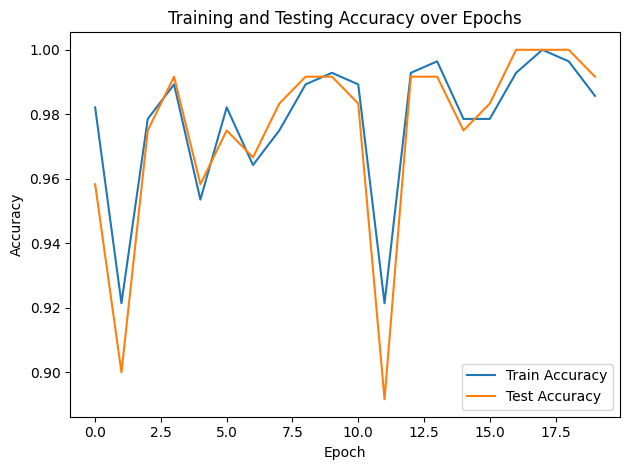

In [88]:
# Plotting the training and testing accuracies
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy over Epochs')
plt.tight_layout()
plt.show()

About the author
================


In [9]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1708813854.662059
Sat Feb 24 15:30:54 2024
